# First-class Caching in Hamilton

References:
- [DiskCache and list of relevant libraries](https://github.com/grantjenks/python-diskcache)
- [Use I/O instead of in-memory data passing](https://joblib.readthedocs.io/en/latest/memory.html#shelving-using-references-to-cached-values)


In [1]:
import logging

logger = logging.getLogger("hamilton.caching.adapters")
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

from hamilton import registry
registry.disable_autoload()
registry.load_extension("pandas")

%load_ext hamilton.plugins.jupyter_magic

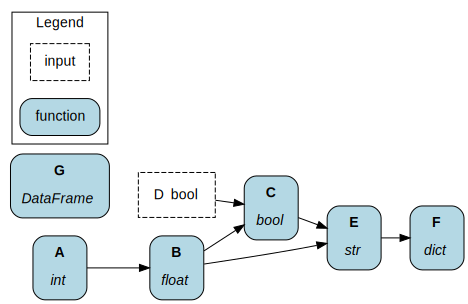

In [2]:
%%cell_to_module primitives -d
import pandas as pd
from hamilton.function_modifiers import tag

def A() -> int:
    return 7

def B(A: int) -> float:
    return float(A)

def C(B: float, D: bool) -> bool:
    return B != D

@tag(cache="pickle")
def E(C: bool, B: float) -> str:
    return "hello-world-ok" * int(B)

@tag(cache="json")
def F(E: str) -> dict:
    return {E: E*3}

@tag(cache="parquet")
def G() -> pd.DataFrame:
    return pd.DataFrame({"a": [323, 3235], "b": ["hello", "vorld"]})

# Fingerprinting

In [3]:
from hamilton import driver
from hamilton.caching.adapters import FingerprintingAdapter

fingerprint_adapter = FingerprintingAdapter()
dr = (
    driver.Builder()
    .with_modules(primitives)
    .with_adapters(fingerprint_adapter)
    .build()
)
dr.execute(["A", "B", "C", "D", "E", "F", "G"], inputs=dict(D=True))

fingerprint_adapter.run_fingerprints

{'D': '-CfPRi9ihI3zfF4elKTadA==',
 'A': 'jxTkX87qFnpaNt7dS-olQw==',
 'B': 'Ad7r-oe5OMieyz3LTv_L4g==',
 'C': '-CfPRi9ihI3zfF4elKTadA==',
 'E': 'qYmWHpd4GeW2ozG7rSYGXw==',
 'F': 'Q0FmLVDHwpNB9XGXrriyL2q1k4fjtm5x1pPw2Q==',
 'G': 'TCtsLwovEJ2EIAYt60Q4_w36aBdTnSXVNPQpsA=='}

# Caching

In [13]:
from hamilton import driver
from hamilton.caching import adapters, fingerprinting
from hamilton.caching.store import SQLiteMetadataStore

sqlite_store = SQLiteMetadataStore()
sqlite_store.initialize()

cache_adapter = adapters.SmartCacheAdapter(metadata_store=sqlite_store)
dr = (
    driver.Builder()
    .with_modules(primitives)
    .with_adapters(cache_adapter)
    .build()
)

In [10]:
results = dr.execute(
    ["A", "B", "C", "D", "E", "F", "G"],
    inputs=dict(D=True),
    # overrides=dict(B=4)
)

print(results)

A: cache hit
B: cache hit
C: cache hit
E: cache hit
F: cache hit
G: cache hit


{'A': 7, 'B': 7.0, 'C': True, 'D': True, 'E': 'hello-world-okhello-world-okhello-world-okhello-world-okhello-world-okhello-world-okhello-world-ok', 'F': {'hello-world-okhello-world-okhello-world-okhello-world-okhello-world-okhello-world-okhello-world-ok': 'hello-world-okhello-world-okhello-world-okhello-world-okhello-world-okhello-world-okhello-world-okhello-world-okhello-world-okhello-world-okhello-world-okhello-world-okhello-world-okhello-world-okhello-world-okhello-world-okhello-world-okhello-world-okhello-world-okhello-world-okhello-world-ok'}, 'G':       a      b
0   323  hello
1  3235  vorld}
